### Imports and reading data

In [311]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
#Import scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#Import pipeline
from sklearn.pipeline import Pipeline

from sklearn.neural_network import MLPRegressor

In [312]:
data = pd.read_csv('train.csv')

### Data exploration

In [313]:
# Loop through the data indeces
def extend_snow(data):
    data['snow'] = data['snow'].fillna(0)
    snow = 0
    replaceCounter = 0
    for i in range(len(data)):
        # If snowfall is not 0, save the value
        if data['snow'][i] != 0:
            snow = data['snow'][i]
            # Replace the following 24 hours with the saved value
            replaceCounter = 23
        elif (replaceCounter > 0):
            data['snow'][i] = snow
            replaceCounter -= 1
    return data
    
def avg_temp_of_day(data):
    temp = 0
    temp_count = 0
    for i in range(len(data)):
        temp += data['temp'][i]
        temp_count += 1
        if ((i + 1) % 24 == 0):
            for j in range(24):
                data['avg_temp_of_day'][i-j] = temp / temp_count
            temp = 0
            temp_count = 0
    return data

    

### Data Preprocessing

In [314]:
def preprocess_data(data):

    # Time [time]
    # Splitting time into month, day, hour columns
    data['month'] = data['time'].apply(lambda x: int(x.split('-')[1]))
    data['day'] = data['time'].apply(
        lambda x: int(x.split('-')[2].split(' ')[0]))
    data['hour'] = data['time'].apply(
        lambda x: int(x.split(' ')[1].split(':')[0]))



    # Creating a new column for day of the week (0 = Monday, 6 = Sunday)
    data['date'] = data['time'].apply(lambda x: x.split(' ')[0])
    data['day_of_week'] = pd.to_datetime(data['date']).dt.dayofweek
    # Turning day of the week into a cyclic feature
    data['day_of_week_sin'] = np.sin(data['day_of_week'] * (2 * np.pi / 7))
    data['day_of_week_cos'] = np.cos(data['day_of_week'] * (2 * np.pi / 7))
    # Creating weekend column
    data['weekend'] = data['day_of_week'].apply(lambda x: 1 if x > 4 else 0)

    data = data.drop(['day_of_week'], axis=1)


    # Transform day of the month into a cyclic feature
    data['day_sin'] = np.sin(2 * np.pi * data['day']/31)
    data['day_cos'] = np.cos(2 * np.pi * data['day']/31)
    data = data.drop(['day'], axis=1)

    # Dropping and date column
    data = data.drop(['date'], axis=1)
    

    # Turning hour into a cyclic feature
    data['hour_sin'] = data['hour'].apply(
        lambda x: np.sin(x * (2 * np.pi / 24)))
    data['hour_cos'] = data['hour'].apply(
        lambda x: np.cos(x * (2 * np.pi / 24)))
    data = data.drop(['hour'], axis=1)


    # Tranforming month column
    data['month_sin'] = data['month'].apply(
        lambda x: np.sin(x * (2 * np.pi / 12)))
    data['month_cos'] = data['month'].apply(
        lambda x: np.cos(x * (2 * np.pi / 12)))
    data = data.drop(['month'], axis=1)

    data = data.drop(['time'], axis=1)
    # Temp [temp]

    # Dew Point [dwpt]

    # Humidity [rhum]

    # Hourly Precipitation [prcp]
    #DROP PRCP
    data = data.drop(['prcp'], axis=1)

    # Snow depth [snow]

    data = extend_snow(data)

    # Wind direction [wdir]
    # Transforming wind direction into sin and cos

    data['wdir_sin'] = data['wdir'].apply(
        lambda x: np.sin(x * (2 * np.pi / 360)))
    data['wdir_cos'] = data['wdir'].apply(
        lambda x: np.cos(x * (2 * np.pi / 360)))
    # Dropping wind direction column
    data = data.drop(['wdir'], axis=1)

    # Wind speed [wspd]

    # Peak wind gust [wpgt]

    # Pressure [pres]
    data['pres'] = data['pres'].apply(lambda x: x-1000)

    # Transform condition code into one-hot vectors
    data = pd.get_dummies(data, columns = ["coco"])

    # electricity price [el_price]


    # Create feature for the avg temp of the day
    data['avg_temp_of_day'] = 0
    data = avg_temp_of_day(data)
    
    data = data.fillna(0)

    return data

data = preprocess_data(data)
pd.options.display.max_columns = None
data.head()

/tmp/ipykernel_199562/3581021057.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['snow'][i] = snow
/tmp/ipykernel_199562/3581021057.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['avg_temp_of_day'][i-j] = temp / temp_count


,temp,dwpt,rhum,snow,wspd,wpgt,pres,el_price,consumption,day_of_week_sin,day_of_week_cos,weekend,day_sin,day_cos,hour_sin,hour_cos,month_sin,month_cos,wdir_sin,wdir_cos,coco_1.0,coco_2.0,coco_3.0,coco_4.0,coco_5.0,coco_6.0,coco_7.0,coco_8.0,coco_9.0,coco_10.0,coco_12.0,coco_13.0,coco_14.0,coco_15.0,coco_16.0,coco_17.0,coco_18.0,coco_19.0,coco_20.0,coco_21.0,coco_22.0,coco_23.0,coco_25.0,avg_temp_of_day
0,11.2,10.3,94.0,0.0,7.2,16.7,12.6,0.09016,0.577,0.974928,-0.222521,0,0.201299,0.97953,0.000000,1.000000,-1.0,-1.836970e-16,-0.642788,0.766044,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.6
1,10.7,9.6,93.0,0.0,7.2,13.0,12.6,0.09251,0.594,0.974928,-0.222521,0,0.201299,0.97953,0.258819,0.965926,-1.0,-1.836970e-16,-0.642788,0.766044,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.6
2,9.9,9.0,94.0,0.0,7.2,13.0,12.2,0.08890,0.685,0.974928,-0.222521,0,0.201299,0.97953,0.500000,0.866025,-1.0,-1.836970e-16,-0.642788,0.766044,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.6
3,10.0,8.4,90.0,0.0,7.2,13.0,11.9,0.08735,1.016,0.974928,-0.222521,0,0.201299,0.97953,0.707107,0.707107,-1.0,-1.836970e-16,-0.500000,0.866025,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.6
4,9.0,8.1,94.0,0.0,3.6,13.0,11.4,0.08688,0.677,0.974928,-0.222521,0,0.201299,0.97953,0.866025,0.500000,-1.0,-1.836970e-16,-0.866025,0.500000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.6


In [315]:
#normalize values

minmaxerRhum = MinMaxScaler()
data["rhum"] = minmaxerRhum.fit_transform(data[['rhum']])

minmaxerTemp = MinMaxScaler()
data["temp"] = minmaxerTemp.fit_transform(data[['temp']])

minmaxerDwpt = MinMaxScaler()
data["dwpt"] = minmaxerDwpt.fit_transform(data[['dwpt']])

minmaxerWspd = MinMaxScaler()
data["wspd"] = minmaxerWspd.fit_transform(data[['wspd']])

minmaxerWpgt = MinMaxScaler()
data["wpgt"] = minmaxerWpgt.fit_transform(data[['wpgt']])

minmaxerPres = MinMaxScaler()
data["pres"] = minmaxerPres.fit_transform(data[['pres']])

minmaxerSnow = MinMaxScaler()
data["snow"] = minmaxerSnow.fit_transform(data[['snow']])

#data.head()


### Split the data into training validation testing sets

In [316]:
X = data.drop(['consumption'], axis=1)
y = data['consumption']
#train_test_split for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5 )
print(X_train.shape, y_train.shape)

(6014, 43) (6014,)


In [317]:
if(True):
    # Cross-validation for parameter tuning, using the mean absolute error as the score
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import KFold
    from sklearn.model_selection import cross_val_score
    #Import models
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.ensemble import HistGradientBoostingRegressor
    from sklearn.neural_network import MLPRegressor
    from sklearn.ensemble import RandomForestRegressor

    kf = KFold(n_splits=10,shuffle=True ,random_state=1)
    rf = RandomForestRegressor(random_state=1)
    gbr = GradientBoostingRegressor(random_state=1)
    hgb = HistGradientBoostingRegressor(random_state=1)

    models = [rf, gbr, hgb]


    param_grid = {
        'loss': ['absolute_error'],
        'learning_rate': [0.23],
        'max_iter':[425],
        'max_leaf_nodes': [27],
    }

    grid = GridSearchCV(hgb, param_grid, cv=kf, scoring='neg_mean_absolute_error', verbose=3, n_jobs=-1)
    grid.fit(X,y)


Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [318]:
import sklearn as skl
# Get the mean absolute error on the validation data

print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

-0.4467965077092759
{'learning_rate': 0.23, 'loss': 'absolute_error', 'max_iter': 425, 'max_leaf_nodes': 27}
HistGradientBoostingRegressor(learning_rate=0.23, loss='absolute_error',
                              max_iter=425, max_leaf_nodes=27, random_state=1)


In [319]:
# rf 0.4662252188618
# rf (n estimators = 200) 0.4648049192422
# rf (n estimators = 350) 0.4640107180264
# rf (n estimators = 500, criterion = poisson) 0.4532568934810
# rf (n estimators = 500, criterion = poisson) avg_temp_day_before 0.44570050031861

# gbr 0.5970524860604666
# gbr (loss = huber, learning_rate = 0.21) 0.46681382521333
# gbr (loss = huber, learning_rate = 0.21, n_estimators = 300) 0.4579331869633
# gbr (loss = huber, learning_rate = 0.21, n_estimators = 300, subsample = 1, min_samples_split = 4) 0.4576119234322
# gbr (
# loss = huber, learning_rate = 0.21, n_estimators = 300, subsample = 1, min_samples_split = 4, alpha = 0.85
# ) 0.0.45735913420514607

# hgb 0.5910592077326
# hgb ('learning_rate': 0.2, 'loss': 'absolute_error') 0.4469123007557
# hgb ('learning_rate': 0.23, 'loss': 'absolute_error') 0.4458115277666
# hgb ('learning_rate': 0.23, 'loss': 'absolute_error', 'max_iter': 400) 0.44320934256139
# hgb ('learning_rate': 0.23, 'loss': 'absolute_error', 'max_iter': 400, 'max_leaf_nodes': 27) 0.44121118797168
# hgb ('learning_rate': 0.23, 'loss': 'absolute_error', 'max_iter': 425, 'max_leaf_nodes': 27) 0.44111039623367

### Test model accuracy

In [320]:
gbr_test = GradientBoostingRegressor(
    learning_rate=0.21, loss='huber', n_estimators=300, subsample=1, min_samples_split=4, alpha=0.85, random_state=1
)

rf_test = RandomForestRegressor(n_estimators=500, criterion='poisson')

hgb_test = HistGradientBoostingRegressor(
    learning_rate=0.23, loss='absolute_error', max_iter=400, max_leaf_nodes=27, random_state=1
    )

model_test = rf_test.fit(X_train, y_train)
error = mean_squared_error(y_test, model_test.predict(X_test))
print(error)


0.6964700731634854


### Make a regression model using the training data

In [321]:

gbr = GradientBoostingRegressor(
    learning_rate=0.21, loss='huber', n_estimators=300, subsample=1, min_samples_split=4, alpha=0.85, random_state=1
)

rf = RandomForestRegressor(n_estimators=500, criterion='poisson')

hgb = HistGradientBoostingRegressor(
    learning_rate=0.23, loss='absolute_error', max_iter=400, max_leaf_nodes=27, random_state=1
    )
model = hgb.fit(X, y)

#Plotting feature importance
if (False): # Doesn't work with HistGradientBoostingRegressor
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * \
        (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx], color='white')
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')


### Make predictions using the testing data

In [322]:
make_prediction = True

In [323]:
if make_prediction:
    # Read in the test data
    test_data = pd.read_csv('test.csv')

    # Apply preprocessing to the test data
    test_data = preprocess_data(test_data)
    
    # Get missing columns in the training test, because of one hot vector catecories not being the same in test data
    missing_cols = set( data.columns ) - set( test_data.columns )
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        test_data[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    test_data = test_data[data.columns]
    # Drop consuption
    test_data = test_data.drop(['consumption'], axis=1)
    
    #Normalize in test_data
    test_data["rhum"] = minmaxerRhum.transform(test_data[['rhum']])
    test_data["temp"] = minmaxerTemp.transform(test_data[['temp']])
    test_data["dwpt"] = minmaxerDwpt.transform(test_data[['dwpt']])
    test_data["wspd"] = minmaxerWspd.transform(test_data[['wspd']])
    test_data["wpgt"] = minmaxerWpgt.transform(test_data[['wpgt']])
    test_data["pres"] = minmaxerPres.transform(test_data[['pres']])
    test_data["snow"] = minmaxerSnow.transform(test_data[['snow']])
    
    
    # Make predictions
    prediction = model.predict(test_data)

    # Create a dataframe with the predictions
    test_data = pd.read_csv('test.csv')
    test_data['consumption'] = prediction

    # Save the predictions to a csv file
    submission = test_data[['time', 'consumption']]
    submission.to_csv('submission.csv', index=False)

    # Write X to csv file
    X.to_csv('X.csv', index=False)

/tmp/ipykernel_199562/3581021057.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['avg_temp_of_day'][i-j] = temp / temp_count


In [324]:
submission.head()

,time,consumption
0,2022-08-25 00:00:00+03:00,0.237274
1,2022-08-25 01:00:00+03:00,0.240077
2,2022-08-25 02:00:00+03:00,0.304682
3,2022-08-25 03:00:00+03:00,0.331511
4,2022-08-25 04:00:00+03:00,0.729893


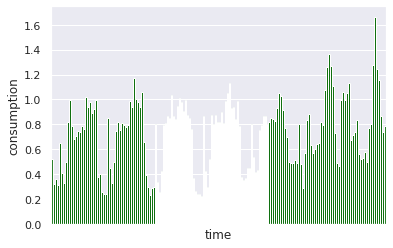

[CV 4/10] END learning_rate=0.23, loss=absolute_error, max_iter=425, max_leaf_nodes=27;, score=-0.450 total time=   4.1s
[CV 2/10] END learning_rate=0.23, loss=absolute_error, max_iter=425, max_leaf_nodes=27;, score=-0.456 total time=   4.4s
[CV 5/10] END learning_rate=0.23, loss=absolute_error, max_iter=425, max_leaf_nodes=27;, score=-0.460 total time=   4.4s
[CV 7/10] END learning_rate=0.23, loss=absolute_error, max_iter=425, max_leaf_nodes=27;, score=-0.448 total time=   4.2s
[CV 6/10] END learning_rate=0.23, loss=absolute_error, max_iter=425, max_leaf_nodes=27;, score=-0.479 total time=   4.4s
[CV 8/10] END learning_rate=0.23, loss=absolute_error, max_iter=425, max_leaf_nodes=27;, score=-0.426 total time=   4.4s
[CV 1/10] END learning_rate=0.23, loss=absolute_error, max_iter=425, max_leaf_nodes=27;, score=-0.471 total time=   4.2s
[CV 9/10] END learning_rate=0.23, loss=absolute_error, max_iter=425, max_leaf_nodes=27;, score=-0.443 total time=   2.1s
[CV 3/10] END learning_rate=0.23

In [305]:
# Graphing the predictions

sns.set()
sns.barplot(x=test_data['time'], y=test_data['consumption'], color='green')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)  # labels along the bottom edge are off
plt.show()



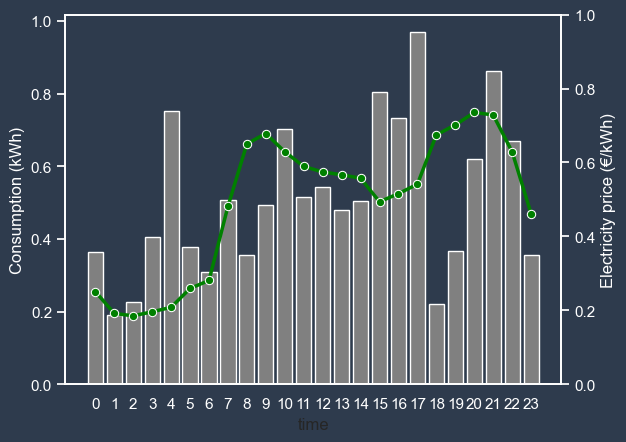

In [249]:
# Graphing 1 day of predictions
sns.set(rc={'axes.facecolor': '#2e3b4d', 'figure.facecolor': '#2e3b4d'})

# Make a df with predictions for 1 day and electricity price
# Take the first 24 hours
day = test_data[:24]
day = day.reset_index(drop=True)
day['el_price'] = test_data.el_price[:24]
day['time'] = day['time'].apply(lambda x: int(x.split(' ')[1].split(':')[0]))

# Plot the predictions
sns.barplot(x=day['time'], y=day['consumption'], color='gray')
sns.lineplot(x=day['time'], y=day['el_price'], color='green', marker='o', linewidth=2.5)
# First y-axis
plt.ylabel('Consumption (kWh)', color='white')
plt.tick_params(colors='white')
plt.grid(False)
# Second y-axis
ax2 = plt.twinx()
ax2.set_ylabel('Electricity price (€/kWh)', color='white')

# Set ax2 text color
ax2.tick_params(axis='y', colors='white')

ax2.grid(False)

plt.show()
# Show only hours
